<AxesSubplot:xlabel='Date'>

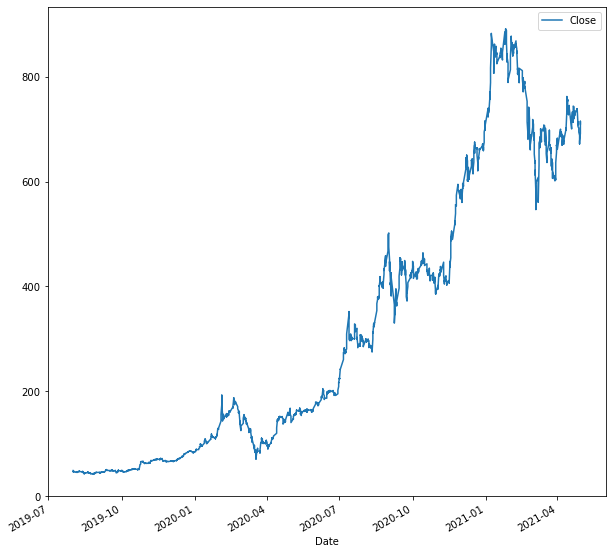

In [74]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline  
 
 
data=yf.download('TSLA',start='2019-08-01', interval='1h',  end='2021-05-01',progress=False)[['Close']]
#data=yf.download('TSLA',start='2021-02-07', interval='1h',  end='2021-05-01',progress=False)[['Close']]
  
data.plot(figsize=(10,10))

In [75]:
data.head()

,Close
Date,
2019-08-01,48.739998
2019-08-01,48.629997
2019-08-01,48.329998
2019-08-01,47.556000
2019-08-01,46.620003


In [76]:
data.shape

(3074, 1)

In [77]:
type(data.values[0][0])

numpy.float64

In [78]:
cl = data.Close.astype('float32')
train = cl[0:int(len(cl)*0.80)]
scl = MinMaxScaler()
#Scale the data
scl.fit(train.values.reshape(-1,1))
cl =scl.transform(cl.values.reshape(-1,1))

#Create a function to process the data into lb observations look back slices
# and create the train test dataset (90-10)
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
        #print(data[i:(i+lb)][9] == data[(i+lb)])
    return np.array(X),np.array(Y)
 
 
lb=10
X,y = processData(cl,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]

In [79]:
#Build the model
model = tf.keras.models.Sequential()
#Output - 254
#input shape - 1 array bestående af 10 arrays (timeseries)
model.add(tf.keras.layers.LSTM(254,input_shape=(lb,1)))
model.add(tf.keras.layers.Dense(units=1))
model.compile(optimizer='adam',loss='mse')
 
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
 
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),shuffle=False)
 
model.summary() 

Epoch 1/100
87/87 [==============================] - 4s 23ms/step - loss: 6.0048e-04 - val_loss: 7.7923e-04
Epoch 2/100
87/87 [==============================] - 2s 19ms/step - loss: 0.0052 - val_loss: 8.1543e-04
Epoch 3/100
87/87 [==============================] - 2s 18ms/step - loss: 0.0053 - val_loss: 8.9408e-04
Epoch 4/100
87/87 [==============================] - 2s 17ms/step - loss: 0.0076 - val_loss: 0.0011
Epoch 5/100
87/87 [==============================] - 1s 16ms/step - loss: 0.0093 - val_loss: 0.0015
Epoch 6/100
87/87 [==============================] - 1s 17ms/step - loss: 0.0109 - val_loss: 0.0012
Epoch 7/100
87/87 [==============================] - 1s 16ms/step - loss: 0.0139 - val_loss: 0.0024
Epoch 8/100
87/87 [==============================] - 1s 17ms/step - loss: 0.0130 - val_loss: 0.0027
Epoch 9/100
87/87 [==============================] - 2s 17ms/step - loss: 0.0120 - val_loss: 0.0045
Epoch 10/100
87/87 [==============================] - 2s 18ms/step - loss: 0.0099 - 

Text(0.5, 1.0, 'Train Dataset')

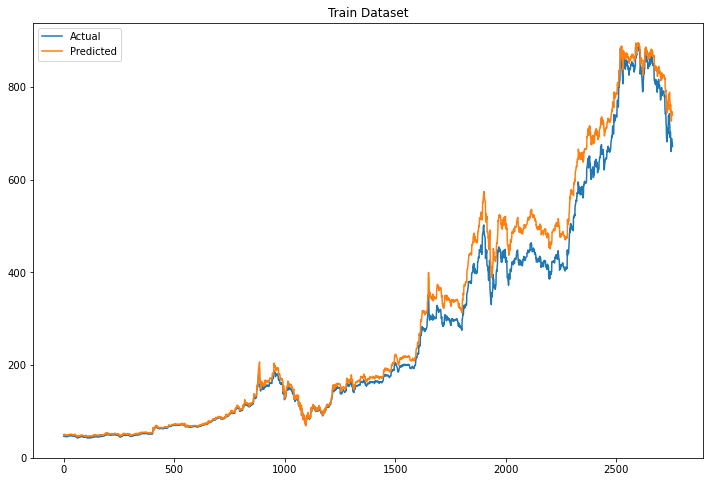

In [80]:
plt.figure(figsize=(12,8))

Xt = model.predict(X_train)
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")

(307, 10, 1)


Text(0.5, 1.0, 'Test Dataset')

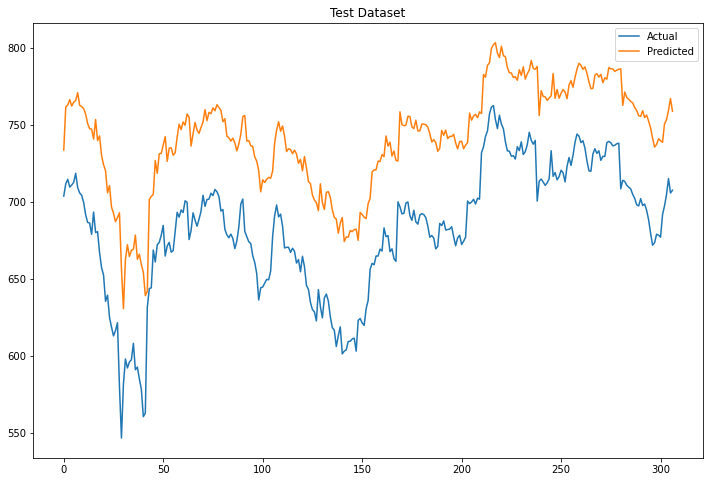

In [81]:
plt.figure(figsize=(12,8))
print(X_test.shape)
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [82]:
model.save('./lstm_stock_prediction')

INFO:tensorflow:Assets written to: ./lstm_stock_prediction/assets


INFO:tensorflow:Assets written to: ./lstm_stock_prediction/assets


In [83]:
#def predictFuture(n, timeseries):

Text(0.5, 1.0, 'Test Dataset')

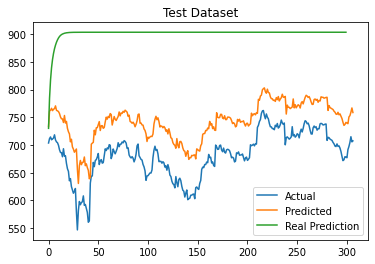

In [84]:
def predictFuture(values:np.ndarray, num_days:int, model:tf.keras.models.Sequential, roll_function) -> []:
    """
    Makes a prediction for the next [num_days] days based on the [values].
    values - a numpy ndarray containing the initial values, e.g. the last 10 days of stock quotes.
    col_range - a list indicating the column names in values, a prediction should be made from, e.g. 1-11.
    num_days - the number of days of the predicition.
    lr - a sklearn LinearRegression object for making the predictions.
    roll_function - a lambda method to shift each value forward in the values ndarray, as to make room for the predicted value.
    """
    
    predictions = []    
    for i in range(0, num_days):
        prediction = model.predict(np.array([values]));
        predictions.append(prediction[0])
        values = roll_function(values)
        values[len(values)-1] = prediction
    
    return predictions
    
predictions = predictFuture(X_test[19], 300, model, lambda x: np.roll(x, -1, 0))
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.plot(scl.inverse_transform(predictions), label="Real Prediction")
plt.legend()
plt.title("Test Dataset")